/var/folders/nc/zbqbbkkx08z7v1g3mlf8bdn00000gn/T/ipykernel_73510/1762310031.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  photo_to_coords = {k: torch.tensor(v).cpu().flatten()[:512] for k, v in photo_to_coords.items()}


Diagnostics: {'iterations': 2000, 'obj': -34547.40021985024, 'mu': 0.40328842989842306, 'sigma': 0.25, 'min_delta': 0.0049510806539880825, 'floor_min': 0.004951080653988151, 'violates_floor': False, 'dimension': 'age'}


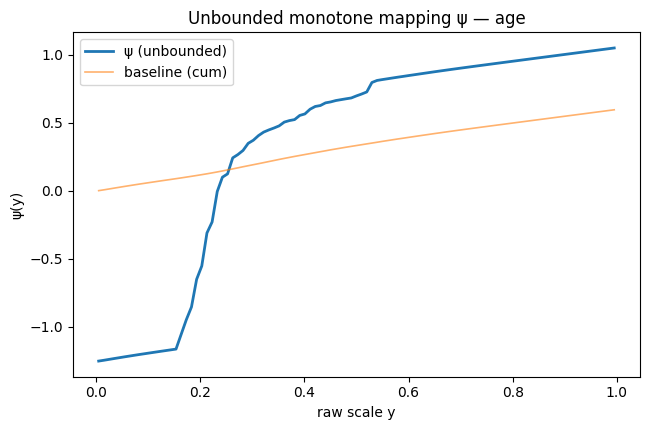

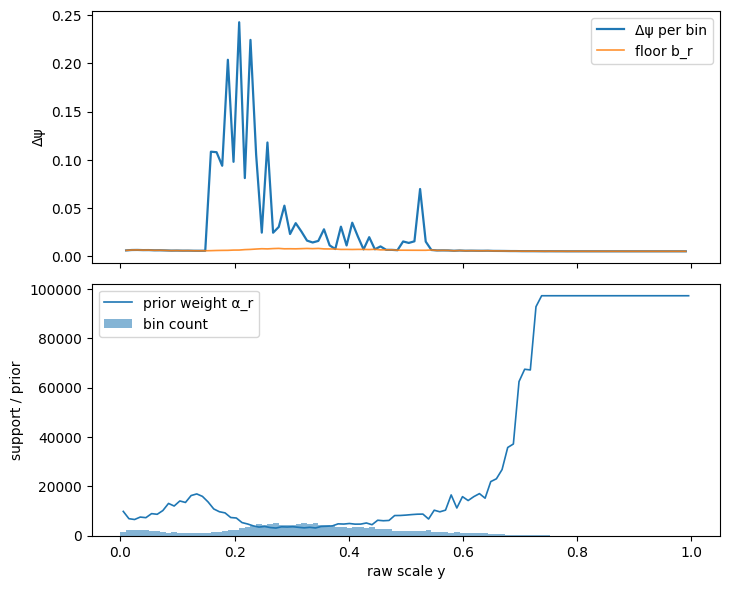

Saved CSVs: scale_learning_age_unbounded/psi_lookup_age_unbounded.csv and scale_learning_age_unbounded/Theta_sigma_age_unbounded.csv


In [3]:
# Unbounded-scale monotone mapping with learned (mu, sigma) around logit
# - Bootstrapped per-item ratings via your loader
# - Heteroscedastic per-item variances
# - Strict per-bin Δψ floor (no flat collapses)
# - Adaptive prior against overconfident tails
# - (mu, sigma) learned via EMA each iteration to make the logit “comfortable”
# - Optional TensorBoard logging

import numpy as np
import pandas as pd
import torch
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Any

# ---------------------------- bootstrap + loader ----------------------------
def bootstrap_tensor(y: torch.Tensor) -> torch.Tensor:
    """
    Vectorized bootstrap with replacement along the last dimension.
    NaNs are ignored; sampling is only from valid entries.
    If a row has <1 valid value, returns NaNs for that row.
    """
    if y.ndim == 1:
        y = y.unsqueeze(0)
    B, R = y.shape
    y_np = y.detach().cpu().numpy()
    out = np.full_like(y_np, np.nan, dtype=np.float32)
    rng = np.random.default_rng(12345)
    for i in range(B):
        row = y_np[i]
        valid_idx = np.where(np.isfinite(row))[0]
        if valid_idx.size == 0:
            continue
        # sample exactly R indices with replacement
        draw = rng.choice(valid_idx, size=R, replace=True)
        out[i] = row[draw]
    return torch.from_numpy(out).to(y.dtype)

def pad_list(l, max_len):
    return l[:max_len] + [np.nan] * (max_len - len(l[:max_len]))

def load_interp_data(base_dir = "/Users/adamsobieszek/PycharmProjects/PsychGAN/", scale=1) -> Tuple[
    Dict[str, torch.Tensor],
    Dict[str, Dict[str, torch.Tensor]]
]:
    """
    Load latent coordinates and ratings, and build bootstrapped rating vectors per item.
    Returns: (photo_to_coords, dim_to_photo_to_ratings)
             where dim_to_photo_to_ratings[dimension][photo] -> 1D torch tensor (bootstrapped ints)
    """
    base_dir = Path(base_dir)
    p2c_path = base_dir / "newer_photo_to_coords.pt"
    d2p2r_path = base_dir / "dim_to_photo_to_ratings2.pkl"
    with open(d2p2r_path, "rb") as f:
        dim_to_photo_to_ratings = pickle.load(f)
    photo_to_coords = torch.load(p2c_path, map_location="cpu")
    photo_to_coords = {k: torch.tensor(v).cpu().flatten()[:512] for k, v in photo_to_coords.items()}

    out = {}
    for dim_name, p2r in dim_to_photo_to_ratings.items():
        # choose an oversample length per dimension (2.5x longest)
        max_len = int(max(len(p2r[kk]) for kk in p2r) * 2.5)
        inner = {}
        for kk, ratings in p2r.items():
            base = torch.tensor(pad_list(ratings, max_len), dtype=torch.float32).reshape(1, -1)
            # Optional global scaling (your code had a small shift when scale!=1)
            base = ((-0.005 if scale != 1 else 0.0) + base) * scale
            boot = bootstrap_tensor(base).reshape(-1)     # 1D vector, ints or floats
            inner[kk] = boot.to(dtype=torch.float32)      # keep as float32 for safety
        out[dim_name] = inner

    return photo_to_coords, out

# ---------------------------- helpers ----------------------------
def diffuse(vec, eps):
    if eps <= 0: return vec
    left = np.zeros_like(vec); right = np.zeros_like(vec)
    left[1:]  = vec[:-1]
    right[:-1]= vec[1:]
    return np.maximum(0.0, (1-2*eps)*vec + eps*(left + right))

def weighted_isotonic(y_vals, w_vals):
    """
    Weighted PAV on an already-ordered 1D grid.
    Returns fitted nondecreasing values (NaNs remain if all weights zero; caller fills).
    """
    mask = w_vals > 0
    y = y_vals[mask]
    w = w_vals[mask]
    if y.size == 0:
        return np.full_like(y_vals, np.nan, dtype=float)

    block_y = y.astype(float).tolist()
    block_w = w.astype(float).tolist()
    block_idx = list(range(len(y)))

    i = 0
    while i < len(block_y) - 1:
        if block_y[i] > block_y[i+1]:
            wy = block_w[i]*block_y[i] + block_w[i+1]*block_y[i+1]
            ww = block_w[i] + block_w[i+1]
            block_y[i] = wy / (ww + 1e-12)
            block_w[i] = ww
            del block_y[i+1]; del block_w[i+1]; del block_idx[i+1]
            if i > 0: i -= 1
        else:
            i += 1

    y_fit_masked = np.empty_like(y)
    for b in range(len(block_y)):
        s = block_idx[b]
        e = block_idx[b+1] if b+1 < len(block_y) else len(y_fit_masked)
        y_fit_masked[s:e] = block_y[b]

    y_fit_full = np.full_like(y_vals, np.nan, dtype=float)
    y_fit_full[mask] = y_fit_masked
    return y_fit_full

def fill_nearest(y_fit, low=None, high=None):
    y = y_fit.copy()
    idx = np.where(~np.isnan(y))[0]
    if idx.size == 0:
        y = np.linspace(0.0, 1.0, len(y))
    else:
        first, last = idx[0], idx[-1]
        for i in range(first-1, -1, -1): y[i] = y[i+1]
        for i in range(last+1, len(y)):  y[i] = y[i-1]
    if low is not None or high is not None:
        low  = -np.inf if low  is None else low
        high =  np.inf if high is None else high
        y = np.clip(y, low, high)
    return y

def logit(p):
    p = np.clip(p, 1e-12, 1 - 1e-12)
    return np.log(p) - np.log(1 - p)

# ---------------------------- Trainer ----------------------------
class MonotoneMappingTrainer:
    def __init__(self, config: Dict[str, Any]):
        self.cfg = config
        self.writer = None
        if self.cfg.get("logging", {}).get("tensorboard", False):
            try:
                from torch.utils.tensorboard import SummaryWriter
                log_dir = self.cfg["logging"].get("log_dir", "./runs/monotone_mapping")
                self.writer = SummaryWriter(log_dir=log_dir)
            except Exception as e:
                print(f"(TensorBoard disabled) {e}")
                self.writer = None

    def _log_scalar(self, name, value, step):
        if self.writer is not None:
            self.writer.add_scalar(name, value, step)

    def fit(self, dim_to_photo_to_ratings: Dict[str, Dict[str, torch.Tensor]], dimension_name_hint="age"):
        # ------------- Pull config -------------
        min_ratings       = self.cfg["data"].get("min_ratings", 10)
        max_iters         = self.cfg["training"].get("max_iters", 200)
        tol               = self.cfg["training"].get("tol", 1e-6)
        sigma_floor       = self.cfg["model"].get("sigma_floor", 1e-4)
        neighbor_diff     = self.cfg["model"].get("neighbor_diffusion", 0.15)
        # Prior
        prior_strength    = self.cfg["model"].get("prior_strength", 3.0)
        prior_power       = self.cfg["model"].get("prior_power", 1.0)
        prior_center      = self.cfg["model"].get("prior_center", "linear_u")  # or "previous"
        # Strict floor
        min_delta_per_bin = self.cfg["model"].get("min_delta_per_bin", 6e-4)
        adaptive_floor_mass = self.cfg["model"].get("adaptive_floor_mass", 0.02)
        baseline_from     = self.cfg["model"].get("baseline_from", "counts")
        # Logit/EMA
        eps               = self.cfg["model"].get("eps", 1.0/202.0)
        ema_rate          = self.cfg["model"].get("ema_rate", 0.25)
        sigma_min_logit   = self.cfg["model"].get("sigma_min_logit", 0.35)

        # ------------- Select dimension & collect data -------------
        dims = list(dim_to_photo_to_ratings.keys())
        dim = next((d for d in dims if dimension_name_hint.lower() in d.lower()), dims[0])
        p2r = dim_to_photo_to_ratings[dim]

        # Filter photos
        def looks_like_target(p):
            try:
                base = Path(p).stem
                n = int(base)
                return 1 <= n <= 1004
            except Exception:
                return False
        photos = sorted([p for p,t in p2r.items() if len(t) >= min_ratings and looks_like_target(p)])
        if not photos:
            photos = sorted([p for p,t in p2r.items() if len(t) >= min_ratings])
        I = len(photos)
        if I == 0:
            raise RuntimeError("No photos with sufficient ratings.")

        photo_idx = {p:i for i,p in enumerate(photos)}
        R_all, idx_i = [], []
        for p in photos:
            # NOTE: these are bootstrapped vectors already (ints/float)
            r = p2r[p].detach().cpu().numpy()
            R_all.append(r)
            idx_i.extend([photo_idx[p]]*len(r))
        R_all = np.concatenate(R_all, axis=0)
        idx_i = np.asarray(idx_i, dtype=np.int32)
        n_i = np.bincount(idx_i, minlength=I).astype(np.int32)

        # rating grid
        grid_r = np.arange(0, 101, dtype=np.int32)
        y_grid = (grid_r + 0.5) / 101.0

        # initialize μ, σ from the raw y distribution
        # clamp away from edges to keep logit sane
        y_all = np.clip((R_all + 0.5) / 101.0, eps, 1 - eps)
        mu = float(y_all.mean())
        sig = float(y_all.std(ddof=0))
        sig = max(sig, sigma_min_logit)

        # Initialize ψ on bins (unbounded scale), start roughly as standardized logit
        u_grid = logit(np.clip(0.5 + (y_grid - mu)/max(sig, 1e-12), eps, 1 - eps))
        u_grid = (u_grid - u_grid.mean()) / (u_grid.std(ddof=0) + 1e-12)
        psi_bins = u_grid.copy()

        Theta = np.zeros(I, dtype=np.float64)
        sigma2 = np.ones(I, dtype=np.float64) * max(sigma_floor**2, 1e-6)

        # Supports per bin (for priors & adaptive floors)
        C_r_raw = np.bincount(R_all.astype(np.int32), minlength=101).astype(np.float64)
        C_r_smooth = diffuse(C_r_raw, neighbor_diff)

        # Per-interval floor b_inc (length 100) and cumulative baseline
        Ninc = 100
        floor_uniform = np.full(Ninc, min_delta_per_bin, dtype=float)
        if adaptive_floor_mass > 0:
            if baseline_from == "counts":
                density = C_r_smooth[:-1] + 1.0
            else:
                density = np.ones(Ninc, dtype=float)
            density = density / (density.sum() + 1e-12)
            floor_adapt = adaptive_floor_mass * density
        else:
            floor_adapt = 0.0
        b_inc = floor_uniform + floor_adapt
        total_floor = float(b_inc.sum())
        if total_floor >= 0.98:  # feasibility
            b_inc *= 0.98 / total_floor
        B_cum = np.concatenate([[0.0], np.cumsum(b_inc)])  # length 101

        prev_obj = None
        for it in range(max_iters):
            # --- current standardized logit grid (depends on μ,σ)
            u_grid = logit(np.clip(0.5 + (y_grid - mu)/max(sig, 1e-12), eps, 1 - eps))
            u_grid_std = (u_grid - u_grid.mean()) / (u_grid.std(ddof=0) + 1e-12)

            # ---- A-step: Θ (item locations on ψ-scale)
            z_all = psi_bins[R_all.astype(np.int32)]
            sum_z = np.bincount(idx_i, weights=z_all, minlength=I).astype(np.float64)
            Theta = sum_z / np.maximum(n_i, 1)
            Theta = (Theta - Theta.mean()) / (Theta.std(ddof=0) + 1e-12)

            # ---- S-step: σ²_i (heteroscedastic per item)
            res = z_all - Theta[idx_i]
            sum_res2 = np.bincount(idx_i, weights=res*res, minlength=I).astype(np.float64)
            sigma2_mle = sum_res2 / np.maximum(n_i, 1)
            sigma2 = np.maximum(sigma2_mle, sigma_floor**2)

            # ---- B-step on φ = ψ - B to enforce Δψ >= b_inc
            w_i = 1.0 / (sigma2 + 1e-12)
            wi_obs = w_i[idx_i]
            # Aggregate to rating bins
            T_r = np.bincount(R_all.astype(np.int32), weights=wi_obs*Theta[idx_i], minlength=101).astype(np.float64)
            W_r = np.bincount(R_all.astype(np.int32), weights=wi_obs,               minlength=101).astype(np.float64)
            # mild diffusion
            T_r = diffuse(T_r, neighbor_diff)
            W_r = diffuse(W_r, neighbor_diff)

            # Prior center for ψ on bins
            if prior_center == "previous":
                prior_mu_psi = psi_bins.copy()
            else:  # "linear_u": shrink toward standardized u_grid
                prior_mu_psi = u_grid_std.copy()

            # Convert to φ prior: μ_φ = μ_ψ - B
            prior_mu_phi = prior_mu_psi - B_cum

            # Prior weights α_r: stronger when support is low
            C_med = np.median(C_r_raw[C_r_raw > 0]) if np.any(C_r_raw > 0) else 1.0
            W_nonzero = W_r[W_r > 0]
            W_med = np.median(W_nonzero) if W_nonzero.size > 0 else 1.0
            alpha_r = prior_strength * W_med * (C_med / (C_r_raw + 1.0))**prior_power
            alpha_r = np.clip(alpha_r, 0.0, 10.0 * W_med)

            # Targets for φ: (m_r - B) with prior
            m_r_phi_num = T_r - W_r * B_cum + alpha_r * prior_mu_phi
            W_r_phi      = W_r + alpha_r
            with np.errstate(divide='ignore', invalid='ignore'):
                m_r_phi = m_r_phi_num / np.maximum(W_r_phi, 1e-12)

            # Weighted isotonic for φ (nondecreasing)
            phi_fit = weighted_isotonic(m_r_phi, W_r_phi)
            phi_fit = fill_nearest(phi_fit)
            phi_fit = np.maximum.accumulate(phi_fit)

            # Recover ψ and guarantee Δψ >= b_inc
            psi_bins = B_cum + phi_fit

            # ---- objective (profile likelihood + prior penalty on φ)
            z_all = psi_bins[R_all.astype(np.int32)]
            res = z_all - Theta[idx_i]
            sum_res2 = np.bincount(idx_i, weights=res*res, minlength=I).astype(np.float64)
            sigma2 = np.maximum(sum_res2 / np.maximum(n_i, 1), sigma_floor**2)
            like = 0.5 * np.sum((sum_res2 / np.maximum(sigma2, 1e-12)) + n_i * np.log(np.maximum(sigma2, 1e-12)))
            prior_pen = 0.5 * np.sum(alpha_r * ((psi_bins - B_cum) - prior_mu_phi)**2)
            obj = like + prior_pen

            # ---- EMA update for (mu, sig) based on weighted y distribution
            W_tot = np.sum(W_r)
            if W_tot > 0:
                mu_hat = float(np.sum(W_r * y_grid) / W_tot)
                var_hat = float(np.sum(W_r * (y_grid - mu_hat)**2) / W_tot)
                sig_hat = float(np.sqrt(max(var_hat, 1e-12)))
            else:
                mu_hat, sig_hat = mu, sig
            mu_prev, sig_prev = mu, sig
            mu = (1 - ema_rate) * mu + ema_rate * mu_hat
            sig = (1 - ema_rate) * sig + ema_rate * max(sig_hat, sigma_min_logit)

            # ---- logging
            dpsi = np.diff(psi_bins)
            self._log_scalar("loss/obj", obj, it)
            self._log_scalar("loss/like", like, it)
            self._log_scalar("loss/prior_pen", prior_pen, it)
            self._log_scalar("geom/min_delta", dpsi.min(), it)
            self._log_scalar("scale/mu", mu, it)
            self._log_scalar("scale/sigma", sig, it)

            # convergence
            if prev_obj is not None and abs(prev_obj - obj) / (abs(prev_obj) + 1e-12) < tol:
                break
            prev_obj = obj

        # ---- outputs ----
        dpsi = np.diff(psi_bins)
        psi_table = pd.DataFrame({
            "rating_int": grid_r,
            "y_unit": y_grid,
            "psi": psi_bins,
            "bin_count": C_r_raw,
            "alpha_prior": alpha_r,
            "baseline_cum": B_cum
        })
        baseline_inc = b_inc.copy()  # length 100

        Theta_df = pd.DataFrame({
            "photo": photos,
            "Theta": Theta,
            "sigma": np.sqrt(sigma2),
            "n": n_i
        })

        diagnostics = dict(
            iterations = it+1,
            obj = float(obj),
            mu = float(mu),
            sigma = float(sig),
            min_delta = float(dpsi.min()),
            floor_min = float(b_inc.min()),
            violates_floor = bool((dpsi < b_inc - 1e-12).any()),
            dimension = dim
        )

        return dict(
            dimension=dim,
            psi_table=psi_table,
            Theta=Theta_df,
            diagnostics=diagnostics,
            baseline_inc=baseline_inc
        )

# ---------------------------- Config ----------------------------
CONFIG = {
    "data": {
        "min_ratings": 10,
        "base_dir": "/Users/adamsobieszek/PycharmProjects/PsychGAN/",
        "bootstrap_scale": 101.0,
    },
    "training": {
        "max_iters": 2000,
        "tol": 1e-6,
    },
    "model": {
        "sigma_floor": 1e-7,
        "neighbor_diffusion": 0.01,
        "prior_strength": 1.0,
        "prior_power": 1.0,
        "prior_center": "linear_u",   # or "previous"
        "min_delta_per_bin": 1/202,
        "adaptive_floor_mass": 0.1,
        "baseline_from": "counts",
        "eps": 1.0/202.0/20,
        "ema_rate": 0.2,
        "sigma_min_logit": 0.25,
    },
    "logging": {
        "tensorboard": True,
        "log_dir": "./runs/monotone_mapping_unbounded"
    }
}

# ---------------------------- Run ----------------------------
# Load bootstrapped data using your loader
photo_to_coords, dim_to_photo_to_ratings = load_interp_data(CONFIG["data"]["base_dir"], scale=CONFIG["data"]["bootstrap_scale"])

# Train
trainer = MonotoneMappingTrainer(CONFIG)
results = trainer.fit(dim_to_photo_to_ratings, dimension_name_hint="age")

psi_table = results["psi_table"]
Theta_df  = results["Theta"]
diagn     = results["diagnostics"]
b_inc     = results["baseline_inc"]
dim_name  = results["dimension"]

print("Diagnostics:", diagn)

# ---------------------------- Visualize ----------------------------
x = psi_table["y_unit"].values
y = psi_table["psi"].values
B = psi_table["baseline_cum"].values
dpsi = np.diff(y)
mid  = (x[:-1] + x[1:]) / 2.0

fig, ax = plt.subplots(1,1, figsize=(6.6,4.4))
ax.plot(x, y, lw=2, label="ψ (unbounded)")
ax.plot(x, B, lw=1.2, alpha=0.6, label="baseline (cum)")
ax.set_xlabel("raw scale y"); ax.set_ylabel("ψ(y)")
ax.set_title(f"Unbounded monotone mapping ψ — {dim_name}")
ax.legend(); plt.tight_layout(); plt.show()

fig, ax = plt.subplots(2,1, figsize=(7.4,6.0), sharex=True)
ax[0].plot(mid, dpsi, lw=1.6, label="Δψ per bin")
ax[0].plot(mid, b_inc, lw=1.2, alpha=0.85, label="floor b_r")
ax[0].set_ylabel("Δψ"); ax[0].legend()
ax[1].bar(x, psi_table["bin_count"].values, width=1/101, alpha=0.55, label="bin count")
ax[1].plot(x, psi_table["alpha_prior"].values, lw=1.2, label="prior weight α_r")
ax[1].set_xlabel("raw scale y"); ax[1].set_ylabel("support / prior"); ax[1].legend()
plt.tight_layout(); plt.show()

# Save artifacts
out_dir = Path("./scale_learning_age_unbounded")
out_dir.mkdir(parents=True, exist_ok=True)
psi_csv   = out_dir / f"psi_lookup_{dim_name}_unbounded.csv"
theta_csv = out_dir / f"Theta_sigma_{dim_name}_unbounded.csv"
psi_table.to_csv(psi_csv, index=False)
Theta_df.to_csv(theta_csv, index=False)
print("Saved CSVs:", psi_csv, "and", theta_csv)

In [4]:
((y-y.min())/(y.max()-y.min())*0.99+0.005)

array([0.005     , 0.00753477, 0.01024606, 0.0129869 , 0.01564955,
       0.0183279 , 0.02090767, 0.02349931, 0.0260224 , 0.0284595 ,
       0.03092162, 0.0333363 , 0.03576255, 0.03813829, 0.04050428,
       0.04288514, 0.08944752, 0.13578206, 0.17606356, 0.26362771,
       0.30567403, 0.40997585, 0.44476922, 0.5411952 , 0.58643665,
       0.59689186, 0.64755938, 0.6579819 , 0.67097485, 0.69346991,
       0.70331465, 0.71800052, 0.72898639, 0.73588705, 0.74195303,
       0.748721  , 0.76066805, 0.76544973, 0.7685884 , 0.78171248,
       0.7864498 , 0.80133802, 0.81004873, 0.81303279, 0.82146931,
       0.82449731, 0.82881373, 0.83160639, 0.83438463, 0.8370076 ,
       0.84352711, 0.84939583, 0.8559847 , 0.88590243, 0.89235416,
       0.89507457, 0.89759488, 0.9001385 , 0.90265405, 0.90502819,
       0.90751278, 0.90989646, 0.91230644, 0.91468889, 0.91705335,
       0.91944518, 0.9217573 , 0.92405948, 0.92633728, 0.9285778 ,
       0.93081331, 0.93300558, 0.93519272, 0.93737989, 0.93955

In [5]:
# ------------------ Live Visualizer (Plotly, async) v2 ------------------
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display
from concurrent.futures import ThreadPoolExecutor
from queue import Queue, Empty, Full
import numpy as np
import torch
DEVICE = torch.device('mps')
class LiveInverseMappingVisualizer:
    """
    Column 1 (spans rows): mapping ψ(y) vs best linear baseline.
    Column 2 (rows 1..3): three example items stacked, hist of z=ψ(y) and current N(Θ,σ²) pdf.
    Column 3 (spans rows): scatter of Beta(α,β) fitted on re-scaled transformed ratings
                           z -> y_tilde in [0.005, 0.995] via global min/max.
    """
    def __init__(self, dataset, example_item_ids=None, grid_points=401, hist_bins=30,
                 beta_clip=(0.005, 0.995), kappa_min=1e-3):
        self.ds = dataset
        self.grid_points = int(grid_points)
        self.hist_bins = int(hist_bins)
        self.beta_clip = beta_clip
        self.kappa_min = float(kappa_min)

        # Choose 3 examples: low/median/high mean on raw unit scale
        if example_item_ids is None:
            means = []
            for r in self.ds.ratings:
                y_int = r.clone().float()
                y = torch.where(torch.isnan(y_int), y_int,
                                torch.clamp((y_int + 0.5)/101.0, 1e-6, 1-1e-6))
                y = y[~torch.isnan(y)]
                means.append(0.5 if y.numel()==0 else float(y.mean()))
            order = np.argsort(means)
            lo = int(order[max(0, int(0.1 * len(order)) - 1)])
            md = int(order[int(0.5 * len(order))])
            hi = int(order[min(len(order)-1, int(0.9 * len(order)))])
            example_item_ids = [lo, md, hi]
        self.example_item_ids = example_item_ids

        # Figure: rows=3, cols=3; col1 spans all rows; col3 spans all rows; col2 has 3 stacked plots
        specs = [
            [{"type":"xy", "rowspan":3}, {"type":"xy"}, {"type":"xy", "rowspan":3}],
            [None,                    {"type":"xy"}, None],
            [None,                    {"type":"xy"}, None],
        ]
        titles = (
            "Mapping ψ(y) (red) & Best Linear Baseline (gray)",
            f"Example #{self.example_item_ids[0]}",
            f"Example #{self.example_item_ids[1]}",
            f"Example #{self.example_item_ids[2]}",
            "Beta(α, β) over items"
        )
        self.fig = go.FigureWidget(make_subplots(
            rows=3, cols=3, specs=specs, column_widths=[0.55, 0.25, 0.20],
            subplot_titles=(titles[0], titles[1], titles[2], titles[3], titles[4])
        ))

        # Column 1 (row 1 span): baseline + ψ
        self.fig.add_trace(go.Scatter(mode="lines", line=dict(color="gray", width=2, dash="dash"),
                                      name="baseline", showlegend=False), row=1, col=1)
        self.fig.add_trace(go.Scatter(mode="lines", line=dict(color="red", width=3),
                                      name="psi", showlegend=False), row=1, col=1)

        # Column 2: three example panels (each bar + pdf)
        colors = ["#729ECE", "#8EBA42", "#FF9DA7"]
        for r in (1,2,3):
            cidx = r-1
            self.fig.add_trace(go.Bar(name=f"hist{r}", marker=dict(color=colors[cidx], opacity=0.45),
                                      showlegend=False), row=r, col=2)
            self.fig.add_trace(go.Scatter(mode="lines", line=dict(color=colors[cidx], width=2),
                                          name=f"pdf{r}", showlegend=False), row=r, col=2)

        # Column 3 (row 1 span): alpha-beta scatter
        self.fig.add_trace(go.Scatter(mode="markers",
                                      marker=dict(size=6, color="#444", opacity=0.6),
                                      name="Beta αβ", showlegend=False), row=1, col=3)

        # Axes labels
        self.fig.update_xaxes(title_text="y (slider in [0,1])", row=1, col=1)
        self.fig.update_yaxes(title_text="ψ(y)", row=1, col=1)
        for r in (1,2,3):
            self.fig.update_xaxes(title_text="z = ψ(y)", row=r, col=2)
            self.fig.update_yaxes(title_text="density", row=r, col=2)
        self.fig.update_xaxes(title_text="α (Beta)", row=1, col=3)
        self.fig.update_yaxes(title_text="β (Beta)", row=1, col=3)

        self.fig.update_layout(width=1800, height=760, title_text="Live Inverse Mapping Training",
                               margin=dict(l=50,r=20,t=60,b=40))

        display(self.fig)

        # Async infra
        self.executor = ThreadPoolExecutor(max_workers=1)
        self.plot_data_queue = Queue(maxsize=1)

        # Cache all items' unit ratings (list of np arrays)
        self._all_unit_ratings = []
        for r in self.ds.ratings:
            y_int = r.clone().float()
            y = torch.where(torch.isnan(y_int), y_int,
                            torch.clamp((y_int + 0.5)/101.0, 1e-6, 1-1e-6))
            y = y[~torch.isnan(y)]
            self._all_unit_ratings.append(y.cpu().numpy())
        # Cache 3 examples
        self._cached_unit_examples = {iid: self._all_unit_ratings[iid] for iid in self.example_item_ids}

    @torch.no_grad()
    def _prepare_and_queue_data(self, psi_model, emb_module):
        device = next(psi_model.parameters()).device

        # --- Mapping curve ---
        ygrid = torch.linspace(1e-6, 1-1e-6, self.grid_points, device=device)
        zgrid_t = psi_model(ygrid)
        zgrid = zgrid_t.detach().cpu().numpy()
        y_np = ygrid.detach().cpu().numpy()
        # Best linear baseline a + b*y
        X = np.stack([np.ones_like(y_np), y_np], axis=1)
        a_b, *_ = np.linalg.lstsq(X, zgrid, rcond=None)
        z_lin = X @ a_b

        # --- Three example items (z hist + current Gaussian pdf) ---
        hist_data = []
        for iid in self.example_item_ids:
            y_unit = self._cached_unit_examples[iid]
            if y_unit.size == 0:
                hist_data.append({"x": np.array([]), "h": np.array([]), "pdf_x": np.array([]), "pdf_y": np.array([])})
                continue
            yt = torch.tensor(y_unit, device=device, dtype=torch.float32)
            z = psi_model(yt).detach().cpu().numpy()
            zmin, zmax = np.quantile(z, [0.01, 0.99]) if z.size>1 else (float(z.min()), float(z.max()+1e-6))
            edges = np.linspace(zmin, zmax, self.hist_bins+1)
            centers = 0.5*(edges[:-1] + edges[1:])
            counts, _ = np.histogram(z, bins=edges, density=True)

            theta_i, sigma_i = emb_module(torch.tensor([iid], device=device))
            mu = float(theta_i.squeeze().detach().cpu().numpy())
            sd = max(1e-6, float(sigma_i.squeeze().detach().cpu().numpy()))
            pdf_x = np.linspace(zmin, zmax, 200)
            pdf_y = (1.0/(np.sqrt(2*np.pi)*sd)) * np.exp(-(pdf_x-mu)**2/(2*sd**2))

            hist_data.append({"x": centers, "h": counts, "pdf_x": pdf_x, "pdf_y": pdf_y})

        # --- Alpha-Beta scatter from Beta fits on re-scaled transformed ratings ---
        # 1) compute global z_min/z_max across all items
        z_global_min = np.inf
        z_global_max = -np.inf
        for arr in self._all_unit_ratings:
            if arr.size == 0: continue
            yt = torch.tensor(arr, device=device, dtype=torch.float32)
            z  = psi_model(yt).detach().cpu().numpy()
            if z.size == 0: continue
            z_global_min = min(z_global_min, float(np.min(z)))
            z_global_max = max(z_global_max, float(np.max(z)))
        if not np.isfinite(z_global_min) or not np.isfinite(z_global_max) or z_global_max <= z_global_min:
            z_global_min, z_global_max = -1.0, 1.0  # safe default

        lo, hi = self.beta_clip
        alpha_list, beta_list = [], []
        for arr in self._all_unit_ratings:
            if arr.size < 2:
                alpha_list.append(np.nan); beta_list.append(np.nan); continue
            yt = torch.tensor(arr, device=device, dtype=torch.float32)
            z  = psi_model(yt).detach().cpu().numpy()
            if z.size < 2:
                alpha_list.append(np.nan); beta_list.append(np.nan); continue
            # affine map to [lo,hi]
            ztil = (z - z_global_min) / max(1e-12, (z_global_max - z_global_min))
            ytil = np.clip(lo + (hi - lo) * ztil, lo, hi)
            m = float(np.mean(ytil))
            v = float(np.var(ytil, ddof=1)) if ytil.size>1 else 1e-6
            m = np.clip(m, lo, hi)
            v = max(v, 1e-8)
            denom = m*(1-m)
            if denom <= 1e-8:
                kappa = 1e6
            else:
                kappa = max(self.kappa_min, denom / v - 1.0)
            alpha = m * kappa
            beta  = (1.0 - m) * kappa
            alpha_list.append(alpha)
            beta_list.append(beta)

        alpha_arr = np.array(alpha_list, dtype=np.float64)
        beta_arr  = np.array(beta_list,  dtype=np.float64)
        valid = np.isfinite(alpha_arr) & np.isfinite(beta_arr) & (alpha_arr>0) & (beta_arr>0)
        alpha_arr = alpha_arr[valid]
        beta_arr  = beta_arr[valid]

        # Push latest frame
        payload = (y_np, zgrid, z_lin, hist_data, alpha_arr, beta_arr)
        try:
            self.plot_data_queue.get_nowait()
        except Empty:
            pass
        try:
            self.plot_data_queue.put_nowait(payload)
        except Full:
            pass

    def update_async(self, psi_model, emb_module):
        self.executor.submit(self._prepare_and_queue_data, psi_model, emb_module)

    def check_and_update_plot(self):
        try:
            y_np, zgrid, z_lin, hist_data, alpha_arr, beta_arr = self.plot_data_queue.get_nowait()
        except Empty:
            return
        with self.fig.batch_update():
            # Column 1 (mapping: traces 0,1)
            self.fig.data[0].x = y_np
            self.fig.data[0].y = z_lin
            self.fig.data[1].x = y_np
            self.fig.data[1].y = zgrid

            # Column 2 (examples): traces 2..7 (bar,pdf)x3
            for r in range(3):
                base = 2 + 2*r
                h = hist_data[r]
                self.fig.data[base + 0].x = h["x"]
                self.fig.data[base + 0].y = h["h"]
                self.fig.data[base + 1].x = h["pdf_x"]
                self.fig.data[base + 1].y = h["pdf_y"]

            # Column 3 (scatter): trace 8
            self.fig.data[8].x = alpha_arr
            self.fig.data[8].y = beta_arr


In [6]:
# --- NEW: compute item location statistic over [0,1] ---
def compute_item_locations_unit(dataset, stat="mean"):
    ms = []
    for r in dataset.ratings:
        y_int = r.clone().float()
        y = torch.where(torch.isnan(y_int), y_int, torch.clamp((y_int + 0.5)/101.0, 1e-6, 1-1e-6))
        y = y[~torch.isnan(y)]
        if y.numel() == 0:
            ms.append(0.5)
        else:
            ms.append(float(y.mean() if stat == "mean" else y.median()))
    return np.array(ms, dtype=np.float64)

# --- NEW: simple, stable density-reweighting over m in [0,1] via histogram ---
def make_density_weights_from_m(ms, bins=20, target="uniform",
                                clip_min=0.33, clip_max=3.0, gamma=0.75, eps=1e-6) -> torch.Tensor:
    ms = np.clip(ms, 1e-6, 1-1e-6)
    hist, edges = np.histogram(ms, bins=bins, range=(0,1), density=False)
    N = ms.shape[0]
    binwidth = (edges[1] - edges[0])
    # empirical density per unit x
    dens = (hist + eps) / (N * binwidth + eps * bins)
    # map each m to its bin density
    idx = np.minimum(bins-1, (ms * bins).astype(int))
    p_emp = dens[idx]
    # target density: uniform on [0,1] => 1.0 per unit x
    if target == "uniform":
        p_tgt = np.ones_like(p_emp)
    else:
        # placeholder for custom target; default to uniform
        p_tgt = np.ones_like(p_emp)

    w = p_tgt / (p_emp + eps)
    w = np.clip(w, clip_min, clip_max) ** gamma
    w = w / w.mean()  # normalize to mean 1
    return torch.tensor(w, dtype=DTYPE)


In [7]:
# ================== STOCHASTIC BIN + EDGE SAMPLER ==================

def _fit_item_logit_params_from_unit(y_unit: torch.Tensor, eps: float, mu0: float, s0: float, kappa: float):
    mask_int = (y_unit > eps) & (y_unit < 1.0 - eps)
    if mask_int.sum() < 2:
        return mu0, max(1e-3, s0)
    z = torch.logit(torch.clamp(y_unit[mask_int], eps, 1 - eps))
    mu_hat = z.mean().item()
    s_hat  = z.std(unbiased=False).item()
    n = int(mask_int.sum().item())
    lam = kappa / (kappa + n)
    mu_shr = (1 - lam) * mu_hat + lam * mu0
    s_shr  = float(np.sqrt(max((1 - lam) * (s_hat**2) + lam * (s0**2), 1e-6)))
    return mu_shr, s_shr

def precompute_item_logit_EB(dataset, eps: float, kappa: float):
    # global prior from pooled interior logits
    all_z = []
    for r in dataset.ratings:
        y_int = r.clone().float()
        y = torch.where(torch.isnan(y_int), y_int, torch.clamp((y_int + 0.5)/101.0, 1e-6, 1-1e-6))
        mask = (y > eps) & (y < 1 - eps)
        if mask.any():
            all_z.append(torch.logit(torch.clamp(y[mask], eps, 1 - eps)))
    if len(all_z) == 0:
        mu0, s0 = 0.0, 1.0
    else:
        Z = torch.cat(all_z)
        mu0, s0 = float(Z.mean()), float(max(Z.std(unbiased=False).item(), 0.25))

    mu_i, s_i = [], []
    for r in dataset.ratings:
        y_int = r.clone().float()
        y = torch.where(torch.isnan(y_int), y_int, torch.clamp((y_int + 0.5)/101.0, 1e-6, 1-1e-6))
        y = y[~torch.isnan(y)]
        m, s = _fit_item_logit_params_from_unit(y, eps, mu0, s0, kappa)
        mu_i.append(m); s_i.append(s)
    return mu0, s0, np.array(mu_i, dtype=np.float64), np.array(s_i, dtype=np.float64)

class StochasticEdgeAndBinSampler:
    """
    Uniform within integer bins; edges (0/100) via truncated Normal in logit
    with per-item (mu_i, s_i*k), global tail multiplier k (learned by MLE).
    """
    def __init__(self, mu_i: np.ndarray, s_i: np.ndarray, eps: float, tail_mult: float = 1.5, device=DEVICE):
        self.mu_i = torch.tensor(mu_i, dtype=DTYPE, device=device)
        self.s_i  = torch.tensor(s_i,  dtype=DTYPE, device=device)
        self.eps = float(eps)
        self.tail_mult = float(tail_mult)
        self.N01 = torch.distributions.Normal(0., 1.)
        self.c_left  = float(torch.logit(torch.tensor(self.eps)).item())
        self.c_right = float(torch.logit(torch.tensor(1 - self.eps)).item())

    def set_tail_mult(self, k: float):
        self.tail_mult = float(max(0.05, k))

    def _trunc_left(self, mu, sd, c, n):
        alpha = (c - mu) / sd
        base = torch.clamp(self.N01.cdf(alpha), 1e-9, 1-1e-9)
        U = torch.rand(n, device=mu.device)
        p = U * base
        z = torch.clamp(self.N01.icdf(p), -12., 12.)
        return mu + sd * z

    def _trunc_right(self, mu, sd, d, n):
        alpha = (d - mu) / sd
        base = torch.clamp(self.N01.cdf(alpha), 1e-9, 1-1e-9)
        U = torch.rand(n, device=mu.device)
        p = base + (1 - base) * U
        z = torch.clamp(self.N01.icdf(p), -12., 12.)
        return mu + sd * z

    def sample_unit_for_item(self, item_id: int, r_int: torch.Tensor) -> torch.Tensor:
        """
        r_int: tensor of integers 0..100 (with NaNs)
        returns: y in (0,1) with NaNs removed (like your collate previously does)
        """
        r = r_int.clone().to(torch.float32)
        nanmask = torch.isnan(r)
        r = r[~nanmask]
        if r.numel() == 0:
            return torch.tensor([], dtype=torch.float32, device=r_int.device)

        # interior bins: Uniform within bin
        u = torch.rand_like(r)
        y = (r + u) / 101.0

        # edges: replace 0 and 100
        k = self.tail_mult
        mu = self.mu_i[item_id]
        sd = torch.clamp(self.s_i[item_id] * k, 1e-4)

        edge0 = (r <= 0.5)              # original 0 bin
        edge1 = (r >= 99.5)             # original 100 bin
        if edge0.any():
            s = self._trunc_left(mu, sd, self.c_left, int(edge0.sum().item()))
            y[edge0] = torch.sigmoid(s)
        if edge1.any():
            s = self._trunc_right(mu, sd, self.c_right, int(edge1.sum().item()))
            y[edge1] = torch.sigmoid(s)

        return torch.clamp(y, 1e-6, 1-1e-6)


In [8]:
# ============================================
# Monotone inverse-scale training WITHOUT item embeddings
# Per-item μ,σ are estimated a posteriori in transformed space
# and tracked with an EMA used for the OT target.
# ============================================

import os, sys, logging
from typing import List, Optional, Tuple, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Assumes the following are already defined in the notebook/session:
# - LiveInverseMappingVisualizer
# - DEVICE, DTYPE
# - load_interp_data, ItemRatingsDataset, to_unit, collate_items_quantiles

# ------------------ Monotone ψ model ------------------

class MonoPsiGrid(nn.Module):
    """
    Global monotone map ψ on y∈(0,1) via positive derivative on a uniform grid.
    ψ(0)=0 (reference). Strictly increasing via softplus on derivative.
    """
    def __init__(self, M:int=200, eps_floor:float=1e-4):
        super().__init__()
        self.M = int(M)
        self.register_buffer("y_grid", torch.linspace(0., 1., self.M, dtype=DTYPE))
        self.rho = nn.Parameter(torch.zeros(self.M, dtype=DTYPE))   # unconstrained per-grid derivative params
        self.eps_floor = float(eps_floor)
        # Optional global affine (helps gauge/identification)
        self.shift = nn.Parameter(torch.tensor(0., dtype=DTYPE))
        self.scale = nn.Parameter(torch.tensor(1., dtype=DTYPE))

    def deriv_at_grid(self) -> torch.Tensor:
        # ψ'(y_m) = eps + softplus(rho_m)
        return self.eps_floor + torch.nn.functional.softplus(self.rho)

    def psi_grid_values(self) -> torch.Tensor:
        # Integrate derivative over grid (trapezoid). Baseline ψ(0)=0, then apply affine.
        d = self.deriv_at_grid()
        y = self.y_grid
        h = y[1]-y[0]
        d_left  = d[:-1]
        d_right = d[1:]
        inc = 0.5*h*(d_left + d_right)              # area per interval
        psi0 = torch.zeros(1, dtype=DTYPE, device=d.device)
        psi_vals = torch.cat([psi0, torch.cumsum(inc, dim=0)], dim=0)  # length M
        return self.shift + self.scale * psi_vals

    def forward(self, y_query: torch.Tensor) -> torch.Tensor:
        """
        y_query: (...,) in (0,1); returns ψ(y_query).
        Linear interpolation on ψ grid; differentiable w.r.t. parameters.
        """
        y = torch.clamp(y_query, 1e-6, 1-1e-6)
        psi_vals = self.psi_grid_values()
        idx_right = torch.searchsorted(self.y_grid, y)
        idx_right = torch.clamp(idx_right, 1, self.M-1)
        idx_left = idx_right - 1
        y0 = self.y_grid[idx_left]
        y1 = self.y_grid[idx_right]
        psi0 = psi_vals[idx_left]
        psi1 = psi_vals[idx_right]
        t = (y - y0) / torch.clamp(y1 - y0, 1e-12)
        return psi0 + t*(psi1 - psi0)

    # Regularizers
    def curvature_penalty(self) -> torch.Tensor:
        psi = self.psi_grid_values()
        d2 = psi[:-2] - 2*psi[1:-1] + psi[2:]
        return torch.mean(d2**2)

    def floor_barrier(self) -> torch.Tensor:
        d = self.deriv_at_grid()
        target = 2.0*self.eps_floor
        return torch.mean(torch.nn.functional.softplus(target - d)**2)

# ------------------ EMA over per-item μ,σ in transformed space ------------------

class PerItemEMA:
    """
    Track EMA of per-item μ,σ of z=ψ(y), updated from a posteriori batch estimates.
    """
    def __init__(self, num_items:int, alpha:float=0.1, sigma_floor:float=1e-6, device=None, dtype=torch.float32):
        self.num_items   = int(num_items)
        self.alpha       = float(alpha)
        self.sigma_floor = float(sigma_floor)
        self.mu    = torch.zeros(self.num_items, dtype=dtype, device=device)
        self.sigma = torch.ones (self.num_items, dtype=dtype, device=device)

    @torch.no_grad()
    def init_from_loader(self, loader: DataLoader, psi: MonoPsiGrid, device):
        """
        One quick pass to initialize EMA from current ψ.
        Uses all available ratings from the loader.
        """
        psi.eval()
        counts = torch.zeros(self.num_items, dtype=self.mu.dtype, device=device)
        tmp_mu = torch.zeros_like(self.mu)
        tmp_sd = torch.ones_like(self.sigma)  # start from 1

        for batch in loader:
            ids = batch["item_ids"].to(device)
            for i, y_unit in enumerate(batch["y_raw_list"]):
                if y_unit.numel() == 0:
                    continue
                z = psi(to_unit(y_unit.to(device)))
                m = z.mean()
                s = torch.clamp(z.std(unbiased=False), self.sigma_floor)
                tmp_mu[ids[i]] = m
                tmp_sd[ids[i]] = s
                counts[ids[i]] = 1

        mask = counts > 0
        self.mu[mask]    = tmp_mu[mask]
        self.sigma[mask] = tmp_sd[mask]

    @torch.no_grad()
    def update_batch(self, item_ids: torch.Tensor, mu_hat: torch.Tensor, sigma_hat: torch.Tensor):
        a = self.alpha
        self.mu[item_ids]    = (1 - a) * self.mu[item_ids]    + a * mu_hat
        self.sigma[item_ids] = (1 - a) * self.sigma[item_ids] + a * torch.clamp(sigma_hat, self.sigma_floor)

class EMAShim(nn.Module):
    """
    Lightweight shim so the LiveInverseMappingVisualizer can query μ,σ
    like an embedding module: forward(item_ids) -> (mu[:,1], sigma[:,1]).
    """
    def __init__(self, ema: PerItemEMA):
        super().__init__()
        self.ema = ema
    def forward(self, item_ids: torch.Tensor):
        mu = self.ema.mu[item_ids].unsqueeze(-1)
        sigma = self.ema.sigma[item_ids].unsqueeze(-1)
        return mu, sigma

# ------------------ Loss helpers ------------------

def normal_quantiles(tau: torch.Tensor, device=None, dtype=None) -> torch.Tensor:
    dist = torch.distributions.Normal(
        loc=torch.tensor(0., device=device, dtype=dtype),
        scale=torch.tensor(1., device=device, dtype=dtype)
    )
    return dist.icdf(torch.clamp(tau, 1e-6, 1-1e-6))

def estimate_mu_sigma_from_transformed(z: torch.Tensor, sigma_floor: float = 1e-6) -> Tuple[torch.Tensor, torch.Tensor]:
    if z.numel() == 0:
        return torch.tensor(0., dtype=z.dtype, device=z.device), torch.tensor(1., dtype=z.dtype, device=z.device)
    mu = torch.mean(z)
    sd = torch.clamp(z.std(unbiased=False), sigma_floor)
    return mu, sd

def ot_quantile_loss_with_ema(
    psi: MonoPsiGrid,
    item_ids: torch.Tensor,
    Qy_list: List[torch.Tensor],
    ema: PerItemEMA,
    tau: torch.Tensor,
    weights_per_item: Optional[torch.Tensor]=None
) -> torch.Tensor:
    device = item_ids.device
    q_norm = normal_quantiles(tau.to(device), device=device, dtype=DTYPE)
    losses = []
    for b, Qy in enumerate(Qy_list):
        if Qy.numel() == 0:
            continue
        z_q = psi(Qy.to(device))  # ψ(Q_y(τ))
        mu_tgt    = ema.mu[item_ids[b]]
        sigma_tgt = torch.clamp(ema.sigma[item_ids[b]], 1e-6)
        target = mu_tgt + sigma_tgt * q_norm
        e = z_q - target
        l = torch.mean(e**2)
        if weights_per_item is not None:
            l = l * weights_per_item[b]
        losses.append(l)
    if not losses:
        return torch.tensor(0., device=device)
    return torch.mean(torch.stack(losses))

def student_t_nll_aposteriori(
    psi: MonoPsiGrid,
    item_ids: torch.Tensor,
    y_raw_list: List[torch.Tensor],
    nu: float = 6.0,
    sigma_floor: float = 1e-6,
    weights_per_item: Optional[torch.Tensor] = None,
    weight_gamma: float = 1.0
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Robust NLL with per-item μ̂,σ̂ estimated from current transformed ratings.
    Returns: (mean_nll, mu_hat_vec[B], sigma_hat_vec[B])
    """
    device = item_ids.device
    nu_t = torch.tensor(nu, device=device, dtype=DTYPE)
    losses, mu_hats, sigma_hats = [], [], []
    for b, y_unit in enumerate(y_raw_list):
        if y_unit.numel() == 0:
            mu_hat = torch.tensor(0., device=device, dtype=DTYPE)
            sigma_hat = torch.tensor(1., device=device, dtype=DTYPE)
            mu_hats.append(mu_hat); sigma_hats.append(sigma_hat)
            continue
        z = psi(to_unit(y_unit.to(device)))
        mu_hat, sigma_hat = estimate_mu_sigma_from_transformed(z, sigma_floor=sigma_floor)
        mu_hats.append(mu_hat); sigma_hats.append(sigma_hat)
        r = (z - mu_hat) / sigma_hat
        term = ((nu_t + 1.)/2.) * torch.log1p((r**2)/nu_t)
        nll = torch.mean(term) + torch.log(sigma_hat)
        if weights_per_item is not None:
            w = torch.clamp(weights_per_item[b], 1e-6)
            nll = nll * (w ** weight_gamma)
        losses.append(nll)
    if not losses:
        return torch.tensor(0., device=device), torch.stack(mu_hats), torch.stack(sigma_hats)
    return torch.mean(torch.stack(losses)), torch.stack(mu_hats), torch.stack(sigma_hats)



class ItemEmbeddings(nn.Module):
    """
    Per-item Θ and σ (heteroscedastic). σ = σ_min + softplus(ρ).
    """
    def __init__(self, num_items:int, sigma_min:float=1e-3):
        super().__init__()
        self.theta = nn.Embedding(num_items, 1)
        self.rho   = nn.Embedding(num_items, 1)
        nn.init.zeros_(self.theta.weight)
        nn.init.zeros_(self.rho.weight)
        self.sigma_min = sigma_min

    def forward(self, item_ids: torch.Tensor):
        with torch.no_grad():
            if any(self.theta.weight.isnan()) or any(self.rho.weight.isnan()):
                self.theta.weight.data[self.theta.weight.isnan()] = self.theta.weight.data.mean()
                self.rho.weight.data[self.rho.weight.isnan()] = self.rho.weight.data.mean()
        theta = self.theta(item_ids).squeeze(-1)
        sigma = self.sigma_min + torch.nn.functional.softplus(self.rho(item_ids).squeeze(-1))
        return theta, sigma


In [11]:
# ============================================================
# Inverse mapping training: ψ:(0,1)->R learned from per-face
# rating distributions (quantile transport + robust NLL)
# ============================================================

import os, logging, pickle
from pathlib import Path
from typing import Dict, Tuple, List, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ------------------ Utilities: bootstrap & I/O ------------------

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
DTYPE  = torch.float32

def bootstrap_tensor(data: torch.Tensor) -> torch.Tensor:
    """
    Bootstraps along dim=1 (ratings), preserving NaNs, used by load_interp_data.
    Expects shape (1, N) or (B, N); returns same shape.
    """
    if data.dim() == 1:
        data = data.unsqueeze(0)
    B, N = data.shape
    mask = ~torch.isnan(data)
    out = torch.full_like(data, float('nan'))
    for b in range(B):
        valid = data[b, mask[b]]
        if valid.numel() == 0:
            out[b] = torch.full((N,), 0.5, device=data.device, dtype=data.dtype)
            continue
        idx = torch.randint(0, valid.numel(), (N,), device=data.device)
        out[b] = valid[idx]
    return out

def pad_list(l, max_len):
    return l[:max_len] + [np.nan] * (max_len - len(l[:max_len]))

def load_interp_data(base_dir = "/Users/adamsobieszek/PycharmProjects/PsychGAN/", scale=1) -> Tuple[
    Dict[str, torch.Tensor],
    Dict[str, Dict[str, torch.Tensor]]
]:
    """
    Load latent coordinates (unused here), and ratings with bootstrap per image.
    Returns: (photo_to_coords, dim_to_photo_to_ratings)
    """
    base_dir = Path(base_dir)
    p2c_path = base_dir / "newer_photo_to_coords.pt"
    d2p2r_path = base_dir / "dim_to_photo_to_ratings2.pkl"
    with open(d2p2r_path, "rb") as f:
        dim_to_photo_to_ratings = pickle.load(f)
    photo_to_coords = torch.load(p2c_path, map_location="cpu")
    photo_to_coords = {k: torch.tensor(photo_to_coords[k]).cpu().flatten()[:512] for k in photo_to_coords}
    for k in dim_to_photo_to_ratings:
        max_len = int(max(len(dim_to_photo_to_ratings[k][kk]) for kk in dim_to_photo_to_ratings[k]) * 2.5)
        dim_to_photo_to_ratings[k] = {
            kk: bootstrap_tensor(
                    (((-0.005 if scale!=1 else 0.0) + torch.tensor(pad_list(dim_to_photo_to_ratings[k][kk], max_len))).reshape(1, -1)) * scale
                ).reshape(-1)
            for kk in dim_to_photo_to_ratings[k]
        }
    return photo_to_coords, dim_to_photo_to_ratings

# ------------------ Dataset & Collate ------------------

class ItemRatingsDataset(Dataset):
    """
    One sample = one face (item).
    y_raw: raw ratings as integers [0..100] with NaNs padded (bootstrapped in loader).
    We convert to unit scale (0,1) inside collate.
    """
    def __init__(self,
                 dim_to_photo_to_ratings: Dict[str, Dict[str, torch.Tensor]],
                 target_dim: str = "age",
                 min_ratings: int = 10):
        dims = list(dim_to_photo_to_ratings.keys())
        dim = next((d for d in dims if target_dim.lower() in d.lower()), dims[0])
        self.dim_name = dim
        p2r = dim_to_photo_to_ratings[dim]
        items, ratings = [], []
        for photo, r in p2r.items():
            r = torch.as_tensor(r, dtype=torch.float32)
            n_valid = (~torch.isnan(r)).sum().item()
            if n_valid >= min_ratings:
                items.append(photo)
                ratings.append(r)
        self.items = items
        self.ratings = ratings  # list of 1D tensors with NaNs padded

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        return {
            "item_id": idx,
            "photo": self.items[idx],
            "ratings_raw": self.ratings[idx]  # 0..100 with NaNs
        }

def to_unit(y_int: torch.Tensor) -> torch.Tensor:
    # y_int can contain NaNs; keep them
    return torch.where(
        torch.isnan(y_int),
        y_int,
        torch.clamp((y_int + 0.5)/101.0, 1e-6, 1-1e-6)
    )
# --- EDIT: collate now supports stochastic sampler ---
def collate_items_quantiles(batch: List[dict],
                            quantiles: torch.Tensor,
                            subsample_raw: Optional[int]=None,
                            sampler: Optional[StochasticEdgeAndBinSampler]=None):
    item_ids = torch.tensor([b["item_id"] for b in batch], dtype=torch.long)
    Qy_list, y_raw_list, n_list = [], [], []
    for b in batch:
        iid = int(b["item_id"])
        y_int = b["ratings_raw"].clone().detach()
        if sampler is None:
            y = to_unit(y_int)
            y = y[~torch.isnan(y)]
        else:
            y = sampler.sample_unit_for_item(iid, y_int)
        n = y.numel()
        if n == 0:
            Qy = quantiles.clone()
            yv = torch.tensor([], dtype=torch.float32, device=y_int.device)
        else:
            if (subsample_raw is not None) and (n > subsample_raw):
                idx = torch.randint(0, n, (subsample_raw,), device=y.device)
                yv = y[idx]
            else:
                yv = y
            Qy = torch.quantile(y, quantiles.to(y.device))
        Qy_list.append(Qy)
        y_raw_list.append(yv)
        n_list.append(n)
    batch_data = {
        "item_ids": item_ids,
        "Qy_list": Qy_list,
        "y_raw_list": y_raw_list,
        "n_list": torch.tensor(n_list, dtype=torch.float32),
    }
    return batch_data
# --- NEW: standard normal NLL on residuals r = (ψ(y)-Θ)/σ (no constants) ---
def gaussian_resid_nll(psi: MonoPsiGrid,
                       item_ids: torch.Tensor,
                       y_raw_list: List[torch.Tensor],
                       embeddings: ItemEmbeddings) -> torch.Tensor:
    device = item_ids.device
    theta, sigma = embeddings(item_ids)
    losses = []
    for b, y in enumerate(y_raw_list):
        if y.numel() == 0: 
            continue
        z = psi(y.to(device))
        r = (z - theta[b]) / torch.clamp(sigma[b], 1e-6)
        losses.append(0.5 * torch.mean(r**2))   # up to additive const.
    if not losses:
        return torch.tensor(0., device=device)
    return torch.mean(torch.stack(losses))

# ------------------ Monotone ψ model ------------------

class MonoPsiGrid(nn.Module):
    """
    Global monotone map ψ on y∈(0,1) via positive derivative on a uniform grid.
    ψ(0)=0 (reference). Strictly increasing via softplus on derivative.
    """
    def __init__(self, M:int=200, eps_floor:float=1e-4):
        super().__init__()
        self.M = M
        self.register_buffer("y_grid", torch.linspace(0., 1., M, dtype=DTYPE))
        self.rho = nn.Parameter(torch.zeros(M, dtype=DTYPE))   # unconstrained
        self.eps_floor = eps_floor
        # optional global affine (can keep fixed at identity)
        self.shift = nn.Parameter(torch.tensor(0., dtype=DTYPE))
        self.scale = nn.Parameter(torch.tensor(1., dtype=DTYPE))

    def deriv_at_grid(self) -> torch.Tensor:
        # ψ'(y_m) = eps + softplus(rho_m)
        return self.eps_floor + torch.nn.functional.softplus(self.rho)

    def psi_grid_values(self) -> torch.Tensor:
        # Integrate derivative over grid (trapezoid). ψ(0)=0 baseline.
        d = self.deriv_at_grid()
        y = self.y_grid
        # uniform grid spacing
        h = y[1]-y[0]
        # trapezoid cumulative integral
        # integral at grid k: sum over intervals [m,m+1]
        # cum_d_mid = 0.5*(d[m] + d[m+1])
        d_left = d[:-1]
        d_right = d[1:]
        inc = 0.5*h*(d_left + d_right)
        psi0 = torch.zeros(1, dtype=DTYPE, device=d.device)
        psi_vals = torch.cat([psi0, torch.cumsum(inc, dim=0)], dim=0)  # length M
        # affine gauge (learned): scale & shift
        return self.shift + self.scale * psi_vals

    def forward(self, y_query: torch.Tensor) -> torch.Tensor:
        """
        y_query: (...,) in (0,1); returns ψ(y_query).
        Linear interpolates ψ values on grid; differentiable w.r.t. params.
        """
        y = torch.clamp(y_query, 1e-6, 1-1e-6)
        psi_vals = self.psi_grid_values()
        # indices for interpolation
        # searchsorted expects ascending grid; keep in [1, M-1] to have left & right
        idx_right = torch.searchsorted(self.y_grid, y)
        idx_right = torch.clamp(idx_right, 1, self.M-1)
        idx_left = idx_right - 1
        y0 = self.y_grid[idx_left]
        y1 = self.y_grid[idx_right]
        psi0 = psi_vals[idx_left]
        psi1 = psi_vals[idx_right]
        t = (y - y0) / torch.clamp(y1 - y0, 1e-12)
        return psi0 + t*(psi1 - psi0)

    # regularizers helpers
    def curvature_penalty(self) -> torch.Tensor:
        psi = self.psi_grid_values()
        # second differences
        d2 = psi[:-2] - 2*psi[1:-1] + psi[2:]
        return torch.mean(d2**2)

    def floor_barrier(self) -> torch.Tensor:
        d = self.deriv_at_grid()
        # penalize going below a slightly larger floor than eps_floor
        target = 2.0*self.eps_floor
        return torch.mean(torch.nn.functional.softplus(target - d)**2)

class ItemEmbeddings(nn.Module):
    """
    Per-item Θ and σ (heteroscedastic). σ = σ_min + softplus(ρ).
    """
    def __init__(self, num_items:int, sigma_min:float=1e-3):
        super().__init__()
        self.theta = nn.Embedding(num_items, 1)
        self.rho   = nn.Embedding(num_items, 1)
        nn.init.zeros_(self.theta.weight)
        nn.init.zeros_(self.rho.weight)
        self.sigma_min = sigma_min

    def forward(self, item_ids: torch.Tensor):
        theta = self.theta(item_ids).squeeze(-1)
        sigma = self.sigma_min + torch.nn.functional.softplus(self.rho(item_ids).squeeze(-1))
        return theta, sigma

# ------------------ Loss functions ------------------

def normal_quantiles(tau: torch.Tensor, device=None, dtype=None) -> torch.Tensor:
    dist = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=dtype),
                                      scale=torch.tensor(1., device=device, dtype=dtype))
    return dist.icdf(torch.clamp(tau, 1e-6, 1-1e-6))

def ot_quantile_loss(psi: MonoPsiGrid,
                     item_ids: torch.Tensor,
                     Qy_list: List[torch.Tensor],
                     embeddings: ItemEmbeddings,
                     tau: torch.Tensor,
                     weights_per_item: Optional[torch.Tensor]=None) -> torch.Tensor:
    """
    Quantile alignment: ψ(Q_y(τ)) ≈ Θ_i + σ_i Φ^{-1}(τ)
    """
    device = item_ids.device
    q_norm = normal_quantiles(tau.to(device), device=device, dtype=DTYPE)
    theta, sigma = embeddings(item_ids)  # (B,)
    losses = []
    for b, Qy in enumerate(Qy_list):
        z_hat = psi(Qy.to(device))                # shape (K,)
        target = theta[b] + sigma[b] * q_norm     # shape (K,)
        e = z_hat - target
        l = torch.mean(e**2)
        if weights_per_item is not None:
            l = l * weights_per_item[b]
        losses.append(l)
    return torch.mean(torch.stack(losses)) if losses else torch.tensor(0., device=device)
# --- EDIT: add optional item weights to student_t_nll ---
def student_t_nll(psi: MonoPsiGrid,
                  item_ids: torch.Tensor,
                  y_raw_list: List[torch.Tensor],
                  embeddings: ItemEmbeddings,
                  nu: float = 6.0,
                  weights_per_item: Optional[torch.Tensor] = None,
                  weight_gamma: float = 1.0) -> torch.Tensor:
    device = item_ids.device
    theta, sigma = embeddings(item_ids)  # (B,)
    nu_t = torch.tensor(nu, device=device, dtype=DTYPE)
    losses = []
    for b, y_unit in enumerate(y_raw_list):
        if y_unit.numel() == 0:
            continue
        z = psi(y_unit.to(device))
        r = (z - theta[b]) / torch.clamp(sigma[b], 1e-6)
        term = ((nu_t + 1.)/2.) * torch.log1p( (r**2)/nu_t )
        nll = torch.mean(term) + torch.log(torch.clamp(sigma[b], 1e-6))
        if weights_per_item is not None:
            w = torch.clamp(weights_per_item[b], 1e-6)
            nll = nll * (w ** weight_gamma)   # temper inside NLL
        losses.append(nll)
    if not losses:
        return torch.tensor(0., device=device)
    return torch.mean(torch.stack(losses))


def identification_penalty(emb: ItemEmbeddings,
                           item_count:int,
                           lambda_mean:float=1.0,
                           lambda_var:float=1.0) -> torch.Tensor:
    theta_all = emb.theta.weight.squeeze(-1)
    mean_pen = (theta_all.mean())**2
    var_pen  = (theta_all.pow(2).mean() - 1.)**2
    return lambda_mean*mean_pen + lambda_var*var_pen

# ------------------ Trainer ------------------
# ---- MODIFY: Trainer to accept a visualizer and dataset ----
class InverseScaleTrainer:

    def __init__(self, psi_model:MonoPsiGrid,
                 emb:ItemEmbeddings,
                 config:dict,
                 visualizer: LiveInverseMappingVisualizer = None,
                 item_density_weights: Optional[torch.Tensor] = None,
                 
                 sampler: Optional[StochasticEdgeAndBinSampler] = None):   # NEW
        self.sampler = sampler    # NEW:
        self.item_density_weights = item_density_weights  # NEW
        self.psi = psi_model.to(DEVICE)
        self.emb = emb.to(DEVICE)
        params = list(self.psi.parameters()) + list(self.emb.parameters())
        try:
            raise Exception("Ranger")
            sys.path.append('/Users/adamsobieszek/PycharmProjects/_manipy/deixis/pixel2style2pixel/training')
            from ranger import Ranger
       
            self.opt = Ranger(params, lr=config["training"]["learning_rate"],)
                                # weight_decay=config["training"]["weight_decay"])
        except Exception as e:
            self.opt = optim.AdamW(params, lr=config["training"]["learning_rate"],
                                weight_decay=config["training"]["weight_decay"])
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.opt,
            T_max=config["training"]["epochs"] * config["training"]["steps_per_epoch_estimate"]
        )
        self.cfg = config
        self.quantiles = torch.tensor(config["model"]["quantiles"], dtype=DTYPE)
        self.visualizer = visualizer  # <-- new
    # --- NEW: 1D MLE over tail spread k to maximize post-ψ normality ---
    def mle_update_tail_spread(self, loader: DataLoader):
        if not self.sampler or not self.cfg["stochastic_ratings"]["enable"]:
            return
        kmin = self.cfg["stochastic_ratings"]["tail_mult_min"]
        kmax = self.cfg["stochastic_ratings"]["tail_mult_max"]
        K    = self.cfg["stochastic_ratings"]["tail_mult_grid"]
        grid = np.linspace(kmin, kmax, K)

        best_k, best_obj = self.sampler.tail_mult, float('inf')
        self.psi.eval(); self.emb.eval()
        with torch.no_grad():
            for k in grid:
                self.sampler.set_tail_mult(float(k))
                obj_sum, batches = 0.0, 0
                for batch in loader:
                    # NOTE: loader's collate resamples with current sampler automatically
                    item_ids  = batch["item_ids"].to(DEVICE)
                    y_raw_list= batch["y_raw_list"]
                    nll = gaussian_resid_nll(self.psi, item_ids, y_raw_list, self.emb)
                    obj_sum += float(nll.item())
                    batches += 1
                    # keep it light: a few batches suffice
                    if batches >= 10:
                        break
                obj = obj_sum / max(1, batches)
                if obj < best_obj:
                    best_obj, best_k = obj, float(k)

        self.sampler.set_tail_mult(best_k)
        logging.info(f"[MLE] updated tail_mult -> {best_k:.3f} (obj={best_obj:.5f})")

    def train_epoch(self, loader: DataLoader, epoch: int = 0, phase: str = "train") -> dict:
        train = (phase == "train")
        self.psi.train(train)
        self.emb.train(train)

        tot = 0.0
        logs = {"ot": 0., "nll": 0., "curv": 0., "floor": 0., "id": 0.}

        for step, batch in enumerate(loader):
            item_ids   = batch["item_ids"].to(DEVICE)
            Qy_list    = batch["Qy_list"]
            y_raw_list = batch["y_raw_list"]
            n_list     = batch["n_list"].to(DEVICE)

            # === NEW: combine empirical density weights with n_i weighting ===
            if getattr(self, "item_density_weights", None) is not None and self.cfg["reweighting"]["enabled"]:
                w_density = self.item_density_weights[item_ids]
            else:
                w_density = torch.ones_like(n_list)

            scheme = self.cfg["training"].get("item_weighting", "none")
            if scheme == "n":
                w_n = n_list
            elif scheme == "sqrt_n":
                w_n = torch.sqrt(torch.clamp(n_list, 1))
            else:
                w_n = torch.ones_like(n_list)

            pow_n = float(self.cfg["reweighting"].get("n_weight_power", 0.0))
            if pow_n != 0.0:
                n_scaled = (n_list / (n_list.mean() + 1e-8)).clamp(1e-3)
                w_n = w_n * (n_scaled ** pow_n)

            # final combined weights
            w_items = w_density * w_n
            w_items = w_items / (w_items.mean() + 1e-8)

            # === LOSS COMPONENTS ===
            ot_w     = self.cfg["loss_weights"]["ot"]
            nll_w    = self.cfg["loss_weights"]["nll"]
            curv_w   = self.cfg["loss_weights"]["curv"]
            floor_w  = self.cfg["loss_weights"]["floor"]
            id_w     = self.cfg["loss_weights"]["id"]

            # OT (quantile) loss — weighted
            loss_ot = ot_quantile_loss(
                self.psi, item_ids, Qy_list, self.emb,
                tau=self.quantiles, weights_per_item=w_items
            )

            # NLL (Student-t) — optionally weighted / tempered
            if self.cfg["reweighting"].get("apply_to_nll", True):
                nll_gamma = float(self.cfg["reweighting"].get("nll_gamma", 0.5))
                loss_nll = student_t_nll(
                    self.psi, item_ids, y_raw_list, self.emb,
                    nu=self.cfg["model"]["student_t_nu"],
                    weights_per_item=w_items, weight_gamma=nll_gamma
                )
            else:
                loss_nll = student_t_nll(
                    self.psi, item_ids, y_raw_list, self.emb,
                    nu=self.cfg["model"]["student_t_nu"]
                )

            loss_curv = self.psi.curvature_penalty()
            loss_floor = self.psi.floor_barrier()
            loss_id = identification_penalty(
                self.emb,
                item_count=self.emb.theta.num_embeddings,
                lambda_mean=1.0, lambda_var=1.0
            )

            # total weighted loss
            loss = (ot_w * loss_ot
                    + nll_w * loss_nll
                    + curv_w * loss_curv
                    + floor_w * loss_floor
                    + id_w * loss_id)

            # === Optimization ===
            if train:
                self.opt.zero_grad(set_to_none=True)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    list(self.psi.parameters()) + list(self.emb.parameters()),
                    max_norm=self.cfg["training"]["grad_clip_norm"]
                )
                self.opt.step()
                self.scheduler.step()

            # accumulate metrics
            tot += loss.item()
            logs["ot"] += loss_ot.item()
            logs["nll"] += loss_nll.item()
            logs["curv"] += loss_curv.item()
            logs["floor"] += loss_floor.item()
            logs["id"] += loss_id.item()

            # === NEW: Live visualizer hook (unchanged) ===
            if self.visualizer and (phase == "train"):
                if ((step + 1) % self.cfg["logging"]["plot_every_steps"] == 0):
                    self.visualizer.update_async(self.psi, self.emb)
                self.visualizer.check_and_update_plot()

            # === Logging ===
            if (step + 1) % self.cfg["logging"]["print_every"] == 0:
                avg = {k: v / (step + 1) for k, v in logs.items()}
                logging.info(
                    f"[{phase}] epoch {epoch} step {step+1}/{len(loader)} "
                    + " ".join(f"{k}:{avg[k]:.4f}" for k in avg)
                )

        N = max(1, len(loader))
        return {k: v / N for k, v in logs.items()} | {"total": tot / N}

# ------------------ Config ------------------

CONFIG = {
    "data": {
        "dimension": "age",
        "min_ratings": 10,
        "val_split": 0.04,
        "subsample_raw_for_nll": None,  # None or int
        "base_dir": "/Users/adamsobieszek/PycharmProjects/PsychGAN/"
    },
    "model": {
        "grid_M": 200,
        "eps_floor": 1/200/9,
        "student_t_nu": 6.0,
        # 21 quantiles from 0.025..0.975 (mid-tail emphasis)
        "quantiles": [*np.arange(0.01, 0.991, 0.01)],  #[0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975],
        "sigma_min": 1e-3
    },
    "loss_weights": {
        "ot":   1.0,
        "nll":  .75,     # start small; can ramp to 1.0
        "curv": 0,
        "floor":1e-5,
        "id":   1.0
    },
    "training": {
        "epochs": 2000,
        "batch_size": 64,                # number of items (faces) per step
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "grad_clip_norm": 1.0,
        "item_weighting": "n",           # {"n","sqrt_n","uniform"}
        "steps_per_epoch_estimate": 10000  # for cosine scheduler period
    },
    "logging": {
        "level": "INFO",
        "print_every": 10
    }
}

logging.basicConfig(level=CONFIG["logging"]["level"])
CONFIG["logging"].update({
    "plot_every_steps": 100,   # how often to kick async refresh (steps)
    "print_every": 100         # you already have this
})
# --- add to CONFIG ---
CONFIG["reweighting"] = {
    "enabled": True,          # turn density reweighting on/off
    "stat": "mean",           # "mean" or "median" for item location m_i
    "bins": 20,               # histogram bins for empirical density
    "target": "uniform",      # "uniform" (flat over [0,1]) -- simplest and robust
    "clip_min": 0.33,         # clip weights to [clip_min, clip_max]
    "clip_max": 5.0,
    "gamma": 0.75,            # temper weights: w <- w^gamma
    "apply_to_nll": True,     # also weight the NLL term?
    "nll_gamma": 0.5,        # temper again inside NLL (lower variance)
    "n_weight_power": 0.0     # optional combine with n_i weighting (0 = ignore n_i)
}
# --- add to CONFIG ---
CONFIG["stochastic_ratings"] = {
    "enable": False,          # turn on stochastic bin sampling
    "eps": 0.005,            # soft censor bound (half bin)
    "eb_kappa": 8.0,         # EB prior strength for per-item (mu_i, s_i)
    "tail_mult_init": 1.5,   # initial global tail multiplier k
    "tail_mult_min": 0.5,    # search range for k (MLE)
    "tail_mult_max": 3.0,
    "tail_mult_grid": 9,     # #grid points for 1D MLE over k
    "mle_every_epochs": 1,   # re-estimate k every N epochs
    "mc_samples": 1          # draws per rating (keep 1 for speed; loader resamples each call)
}

# ------------------ Train / Validate split & run ------------------

if __name__ == "__main__":
    # Load data (bootstrap inside)
    photo_to_coords, dim_to_photo_to_ratings = load_interp_data(
        base_dir=CONFIG["data"]["base_dir"], scale=101
    )
    # Build dataset
    ds = ItemRatingsDataset(dim_to_photo_to_ratings,
                            target_dim=CONFIG["data"]["dimension"],
                            min_ratings=CONFIG["data"]["min_ratings"])
    N = len(ds)
    idx = np.arange(N)
    np.random.shuffle(idx)
    n_val = max(1, int(CONFIG["data"]["val_split"] * N))
    val_idx = idx[:n_val]
    train_idx = idx[n_val:]

    ds_train = torch.utils.data.Subset(ds, train_idx.tolist())
    ds_val   = torch.utils.data.Subset(ds, val_idx.tolist())

    def _collate(batch):
        return collate_items_quantiles(
            batch,
            quantiles=torch.tensor(CONFIG["model"]["quantiles"], dtype=DTYPE),
            subsample_raw=CONFIG["data"]["subsample_raw_for_nll"]
        )

    train_loader = DataLoader(ds_train, batch_size=CONFIG["training"]["batch_size"],
                              shuffle=True, num_workers=0, collate_fn=_collate)
    val_loader   = DataLoader(ds_val, batch_size=CONFIG["training"]["batch_size"],
                              shuffle=False, num_workers=0, collate_fn=_collate)

    # Models
    psi = MonoPsiGrid(M=CONFIG["model"]["grid_M"], eps_floor=CONFIG["model"]["eps_floor"])
    emb = ItemEmbeddings(num_items=N, sigma_min=CONFIG["model"]["sigma_min"])

    # Initialize Θ, σ from identity ψ (optional)
    # (Quick pass over train set to set rough scales)
    with torch.no_grad():
        all_theta = torch.zeros(N,1)
        all_sigma = torch.zeros(N,1)
        for b in train_loader:
            ids = b["item_ids"]
            # mean & std of ψ(y)=y initially (approx)
            means = []
            sds   = []
            for yv in b["y_raw_list"]:
                if yv.numel()==0:
                    means.append(torch.tensor(0.0))
                    sds.append(torch.tensor(1.0))
                else:
                    m = yv.mean()
                    s = yv.std(unbiased=False)
                    means.append(m)
                    sds.append(s)
            all_theta[ids] = torch.stack(means).unsqueeze(1)
            all_sigma[ids] = torch.stack(sds).unsqueeze(1)
        emb.theta.weight.copy_((all_theta - all_theta.mean())/ (all_theta.std()+1e-6))
        emb.rho.weight.copy_(torch.log(torch.exp(all_sigma - CONFIG["model"]["sigma_min"]) - 1.).clamp(min=-5., max=5.))

    # Visualizer over the FULL dataset indices (embeddings are indexed by full ds)
    live_vis = LiveInverseMappingVisualizer(dataset=ds, example_item_ids=None)
    # --- NEW: compute per-item density weights over item means ---
    m_all = compute_item_locations_unit(ds, stat=CONFIG["reweighting"]["stat"])
    density_w_all = make_density_weights_from_m(
        m_all,
        bins=CONFIG["reweighting"]["bins"],
        target=CONFIG["reweighting"]["target"],
        clip_min=CONFIG["reweighting"]["clip_min"],
        clip_max=CONFIG["reweighting"]["clip_max"],
        gamma=CONFIG["reweighting"]["gamma"]
    ).to(DEVICE)

    trainer = InverseScaleTrainer(psi_model=psi, emb=emb, config=CONFIG, visualizer=live_vis)

    best_val = float("inf")

    for epoch in range(1, CONFIG["training"]["epochs"]+1):
        tr = trainer.train_epoch(train_loader, epoch, phase="train")
        # --- NEW: re-estimate tail spread every N epochs ---
        if CONFIG["stochastic_ratings"]["enable"] and (epoch % CONFIG["stochastic_ratings"]["mle_every_epochs"] == 0):
            trainer.mle_update_tail_spread(train_loader)
        vl = trainer.train_epoch(val_loader,   epoch, phase="val")
        # Force a plot refresh at epoch end, too:
        if live_vis:
            live_vis.update_async(trainer.psi, trainer.emb)
            live_vis.check_and_update_plot()

        val_score = vl["ot"] + CONFIG["loss_weights"]["nll"]*vl["nll"]
        logging.info(f"Epoch {epoch:03d} | "
                     f"train: total={sum(tr.values()):.4f}, "
                     + " ".join([f"{k}:{v:.4f}" for k,v in tr.items()])
                     + f" || val: " 
                     + " ".join([f"{k}:{v:.4f}" for k,v in vl.items()])
                     )
        if val_score < best_val:
            best_val = val_score
            os.makedirs("checkpoints", exist_ok=True)
            torch.save({
                "psi": trainer.psi.state_dict(),
                "emb": trainer.emb.state_dict(),
                "config": CONFIG
            }, "checkpoints/inverse_mapping_best.pt")
            logging.info(f"Saved best model (val score={best_val:.4f})")

    logging.info("Done.")


/var/folders/nc/zbqbbkkx08z7v1g3mlf8bdn00000gn/T/ipykernel_73510/1610034024.py:57: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



FigureWidget({
    'data': [{'line': {'color': 'gray', 'dash': 'dash', 'width': 2},
              'mode': 'lines',
              'name': 'baseline',
              'showlegend': False,
              'type': 'scatter',
              'uid': 'e4dfbb7f-8929-4b71-9306-63fb88ccee24',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'line': {'color': 'red', 'width': 3},
              'mode': 'lines',
              'name': 'psi',
              'showlegend': False,
              'type': 'scatter',
              'uid': '34ddaaac-7f2b-48a9-b1ad-03227379b758',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'marker': {'color': '#729ECE', 'opacity': 0.45},
              'name': 'hist1',
              'showlegend': False,
              'type': 'bar',
              'uid': '829de6e4-e1e0-4f1b-9777-03b18aaf9204',
              'xaxis': 'x2',
              'yaxis': 'y2'},
             {'line': {'color': '#729ECE', 'width': 2},
              'mode': 'lines',
  

INFO:root:Epoch 001 | train: total=12.7439, ot:0.6904 nll:6.3995 curv:0.0000 floor:0.1641 id:0.0000 total:5.4900 || val: ot:nan nll:nan curv:0.0000 floor:0.1637 id:0.0000 total:nan
INFO:root:Epoch 002 | train: total=12.4885, ot:0.6805 nll:6.2652 curv:0.0000 floor:0.1634 id:0.0000 total:5.3794 || val: ot:nan nll:nan curv:0.0000 floor:0.1630 id:0.0000 total:nan
INFO:root:Epoch 003 | train: total=12.3298, ot:0.6731 nll:6.1834 curv:0.0000 floor:0.1627 id:0.0000 total:5.3106 || val: ot:nan nll:nan curv:0.0000 floor:0.1623 id:0.0000 total:nan
INFO:root:Epoch 004 | train: total=12.1247, ot:0.6617 nll:6.0796 curv:0.0000 floor:0.1618 id:0.0000 total:5.2215 || val: ot:nan nll:nan curv:0.0000 floor:0.1613 id:0.0000 total:nan
INFO:root:Epoch 005 | train: total=11.8099, ot:0.6472 nll:5.9169 curv:0.0000 floor:0.1609 id:0.0000 total:5.0849 || val: ot:nan nll:nan curv:0.0000 floor:0.1603 id:0.0000 total:nan
INFO:root:Epoch 006 | train: total=11.6340, ot:0.6377 nll:5.8279 curv:0.0000 floor:0.1598 id:0.

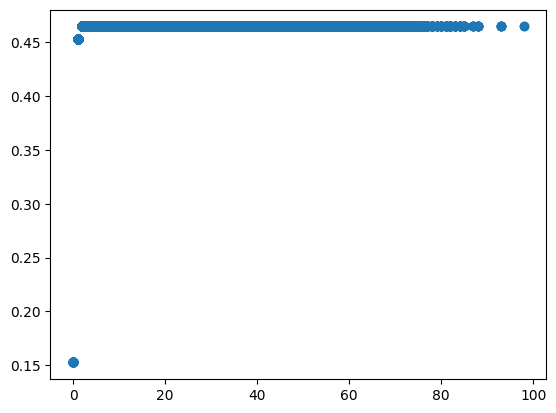

In [ ]:
import matplotlib.pyplot as plt
x = torch.stack(list(ds_train[i]["ratings_raw"] for i in range(len(ds_train)))).mean(dim=1, keepdim=True)
plt.scatter(x.detach().cpu().numpy(),trainer.psi(x).detach().cpu().numpy())